### <b>Installation for the StyleGAN Encoder Network</b>

* Download the pixel2style2pixel (pSp) source code.

<pre>
!git clone https://github.com/eladrich/pixel2style2pixel.git pixel2style2pixel
</pre>

### <b>Installation for the Classification Network</b>

* Download the classification model.

<pre>
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EX15A0wm8MBLrBsT-9ARA-gBZ6W-RwmSw1IgYZzan4dELg?download=1 -O facial_identity_classification_using_transfer_learning_with_ResNet18_resolution_256_normalize_05.pth
</pre>

* Download the Celeb-HQ facial identity recognition dataset.

<pre>
%%capture
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EcWlrJ2qjtRJtQVIwR1kW2EBTj8le3PdXI4TYsKErsGMcA?download=1 -O CelebA_HQ_facial_identity_dataset_test.zip
!unzip CelebA_HQ_facial_identity_dataset_test.zip -d ./CelebA_HQ_facial_identity_dataset_test
</pre>

* Download the corrected facial identity dataset.

<pre>
%%capture
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EQIF7ZqRxDJCjTwWiO1xPe4BqpenC93AEpTnRpSOlrPl5g?download=1 -O corrected_facial_identity_images_ResNet18.zip
!unzip corrected_facial_identity_images_ResNet18.zip -d ./corrected_facial_identity_images_ResNet18
</pre>

### <b>Load the Libraries</b>

* Load the required libraries.

In [5]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from argparse import Namespace
import time
import sys
import pprint
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms

sys.path.append("./pixel2style2pixel")

In [6]:
img_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

data_dir = './CelebA_HQ_facial_identity_dataset_test/'

test_dataset = datasets.ImageFolder(os.path.join(data_dir), img_transforms)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=4)
print('Test dataset size:', len(test_dataset))

class_names = test_dataset.classes
print('Class names:', class_names)

Test dataset size: 1215
Class names: ['102', '1027', '103', '104', '1041', '1043', '1044', '1047', '1052', '1060', '1077', '1079', '108', '1081', '1087', '1090', '1093', '1109', '111', '1112', '112', '1120', '1126', '1133', '1140', '1145', '1149', '1157', '1158', '116', '1191', '121', '1210', '122', '1220', '1237', '124', '125', '1256', '1262', '1268', '1269', '128', '1280', '1285', '129', '1291', '1293', '1307', '1317', '1330', '1335', '1350', '1351', '1370', '1396', '14', '1407', '1427', '1429', '143', '1435', '1440', '1452', '146', '1507', '1515', '1521', '1531', '1538', '1550', '158', '1581', '1584', '1595', '161', '162', '17', '1718', '1730', '175', '177', '1775', '1781', '179', '1796', '180', '1800', '181', '182', '1823', '183', '1837', '1838', '1848', '188', '1904', '1930', '194', '195', '196', '1965', '1972', '1974', '198', '1989', '199', '2020', '203', '2037', '204', '205', '206', '2076', '208', '2116', '2120', '213', '2131', '218', '2193', '2214', '223', '226', '228', '230', 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### <b>Load the Classification Network</b>

* Load the classification model.

In [7]:
save_path = 'facial_identity_classification_using_transfer_learning_with_ResNet18_resolution_256_normalize_05.pth'

model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 307) # multi-class classification (num_of_class == 307)
model.load_state_dict(torch.load(save_path, map_location='cpu'))
model.cuda()

print('The classification model successfully loaded!')

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

The classification model successfully loaded!


In [8]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})


def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()

[Prediction Result Examples]


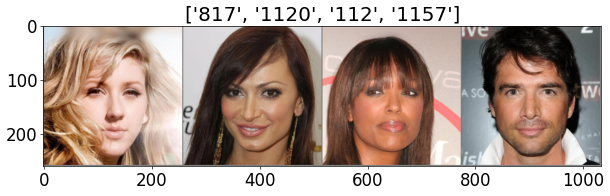

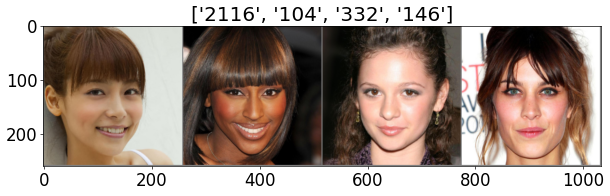

[Test] Loss: 0.5161 Acc: 87.8189% Time: 27.3733s


In [9]:
criterion = nn.CrossEntropyLoss()
model.eval()

start_time = time.time()
with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.cuda()
        labels = labels.cuda()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        if i == 0:
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in labels[:4]])
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in labels[4:8]])

    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects / len(test_dataset) * 100.
    print('[Test] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

### <b>Test Using Generated Dataset</b>

In [10]:
# ref: https://chsasank.github.io/vision/_modules/torchvision/datasets/folder.html
from PIL import Image
import os
import os.path
from torch.utils.data import Dataset

EXTENSIONS = [
    '.png',
]


def is_png_file(filename):
    return any(filename.endswith(extension) for extension in EXTENSIONS)


def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx


def make_dataset(dir, class_to_idx):
    images = []
    dir = os.path.expanduser(dir)
    for target in sorted(os.listdir(dir)):
        d = os.path.join(dir, target)
        if not os.path.isdir(d):
            continue

        for root, _, fnames in sorted(os.walk(d)):
            for fname in sorted(fnames):
                if is_png_file(fname):
                    path = os.path.join(root, fname).split('.png')[0]
                    item = (path + '.png', class_to_idx[target])
                    images.append(item)

    return images


def pil_loader(path):
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')


class CustomFolder(Dataset):
    def __init__(self, root, target_transforms):
        classes, class_to_idx = find_classes(root)
        imgs = make_dataset(root, class_to_idx)

        self.root = root
        self.imgs = imgs
        self.classes = classes
        self.class_to_idx = class_to_idx
        self.pil_loader = pil_loader
        self.target_transforms = target_transforms

    def __getitem__(self, index):
        img, target = self.imgs[index]
        img = self.pil_loader(img)
        img = self.target_transforms(img)
        return img, target

    def __len__(self):
        return len(self.imgs)

In [11]:
data_dir = './corrected_facial_identity_images_ResNet18/corrected_facial_identity_images_ResNet18/'

final_test_dataset = CustomFolder(os.path.join(data_dir), img_transforms)
final_test_dataloader = torch.utils.data.DataLoader(final_test_dataset, batch_size=8, shuffle=True, num_workers=4)
print('Test dataset size:', len(final_test_dataset))

class_names = final_test_dataset.classes
print('Class names:', class_names)

Test dataset size: 814
Class names: ['102', '1027', '103', '104', '1041', '1043', '1044', '1047', '1052', '1060', '1077', '1079', '108', '1081', '1087', '1090', '1093', '1109', '111', '1112', '112', '1120', '1126', '1133', '1140', '1145', '1149', '1157', '1158', '116', '1191', '121', '1210', '122', '1220', '1237', '124', '125', '1256', '1262', '1268', '1269', '128', '1280', '1285', '129', '1291', '1293', '1307', '1317', '1330', '1335', '1350', '1351', '1370', '1396', '14', '1407', '1427', '1429', '143', '1435', '1440', '1452', '146', '1507', '1515', '1521', '1531', '1538', '1550', '158', '1581', '1584', '1595', '161', '162', '17', '1718', '1730', '175', '177', '1775', '1781', '179', '1796', '180', '1800', '181', '182', '1823', '183', '1837', '1838', '1848', '188', '1904', '1930', '194', '195', '196', '1965', '1972', '1974', '198', '1989', '199', '2020', '203', '2037', '204', '205', '206', '2076', '208', '2116', '2120', '213', '2131', '218', '2193', '2214', '223', '226', '228', '230', '

In [12]:
from criteria.lpips.lpips import LPIPS

# LPIPS loss
lpips_loss = LPIPS(net_type='alex')

# reproducible source code
random.seed(777)
np.random.seed(777)
torch.manual_seed(777)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

model.eval()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Downloading: "https://raw.githubusercontent.com/richzhang/PerceptualSimilarity/master/lpips/weights/v0.1/alex.pth" to /root/.cache/torch/hub/checkpoints/alex.pth


  0%|          | 0.00/5.87k [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

[Original Image Examples]


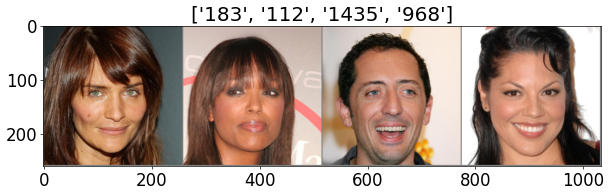

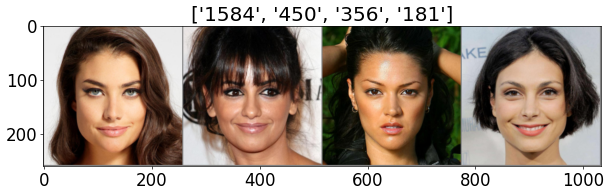

[Original Prediction Result Examples]


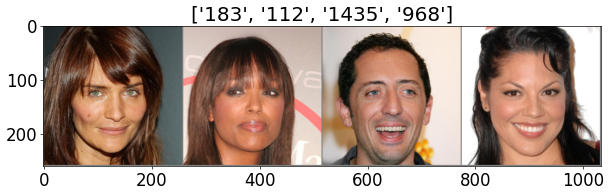

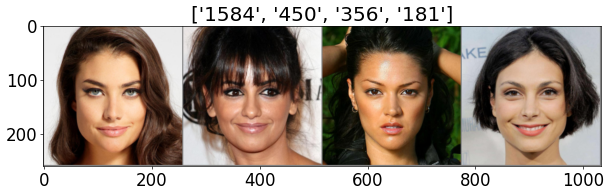

[Test] Original accuracy: 100.0000% Time: 4.4704s


In [13]:
criterion = nn.CrossEntropyLoss()
model.eval()

start_time = time.time()
with torch.no_grad():
    similarity_scores = 0
    lpips_losses = 0
    ori_running_corrects = 0
    encoded_running_corrects = 0
    consistency = 0
    correctly_consistency = 0

    for i, (inputs, labels) in enumerate(final_test_dataloader):
        inputs = inputs.cuda()
        labels = labels.cuda()

        outputs = model(inputs)
        _, ori_preds = torch.max(outputs, 1)
        
        ori_running_corrects += torch.sum(ori_preds == labels.data)
        
        if i == 0:
            print('[Original Image Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in labels[:4]])
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in labels[4:8]])
            print('[Original Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in ori_preds[:4]])
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in ori_preds[4:8]])

    ori_epoch_acc = ori_running_corrects / len(final_test_dataset) * 100.

    print('[Test] Original accuracy: {:.4f}% Time: {:.4f}s'.format(ori_epoch_acc, time.time() - start_time))

### <b>Adversarial Attack</b>

<pre>
!pip install eagerpy
!pip install gitpython
</pre>

* Prepare the foolbox.

<pre>
!git clone https://github.com/ndb796/foolbox_test foolbox
!chmod -R 777 foolbox
</pre>

* (Option) if you want, you can delete previously run results.

```
!rm -rf ./results/
```

In [14]:
!pip install eagerpy
!pip install gitpython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 181 kB 32.8 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 


In [15]:
!git clone https://github.com/ndb796/foolbox_test foolbox
!chmod -R 777 foolbox

Cloning into 'foolbox'...
remote: Enumerating objects: 294, done.
remote: Counting objects: 100% (294/294), done.
remote: Compressing objects: 100% (261/261), done.
remote: Total 294 (delta 29), reused 287 (delta 25), pack-reused 0
Receiving objects: 100% (294/294), 8.50 MiB | 5.27 MiB/s, done.
Resolving deltas: 100% (29/29), done.


In [16]:
sys.path.append("./foolbox")

%load_ext autoreload
%aimport foolbox
%autoreload 2

In [18]:
import foolbox as fb
import foolbox.criteria as criteria
from torchvision.utils import save_image

torch.set_printoptions(precision=6)

In [19]:
def get_distance(a, b):
    l0 = torch.norm((a - b).view(a.shape[0], -1), p=0, dim=1)
    l2 = torch.norm((a - b).view(a.shape[0], -1), p=2, dim=1)
    mse = (a - b).view(a.shape[0], -1).pow(2).mean(1)
    linf = torch.norm((a - b).view(a.shape[0], -1), p=float('inf'), dim=1)
    return l0, l2, mse, linf


def input_normalize(x, min_value, max_value, new_min, new_max):
    return (x - min_value) / (max_value - min_value) * (new_max - new_min) + new_min


def unnormalize(image):
    mean = torch.tensor([0.5, 0.5, 0.5]).view(-1, 3, 1, 1).float()
    std = torch.tensor([0.5, 0.5, 0.5]).view(-1, 3, 1, 1).float()
    
    image = image.detach().cpu()
    image *= std
    image += mean
    image[image < 0] = 0
    image[image > 1] = 1

    return image

def normalize(image):
    mean = torch.tensor([0.5, 0.5, 0.5]).view(-1, 3, 1, 1).float().cuda()
    std = torch.tensor([0.5, 0.5, 0.5]).view(-1, 3, 1, 1).float().cuda()
    
    image = image.clone()
    image -= mean
    image /= std
    
    return image

In [20]:
images_num = 10000

source_index = np.random.choice(len(final_test_dataset), images_num)
target_index = np.random.choice(len(final_test_dataset), images_num)

In [21]:
class CustomNetwork(nn.Module):
    def __init__(self, synthesizer, classifier, face_pool):
        super(CustomNetwork, self).__init__()

        self.classifier = classifier
        self.classifier.eval()

        self.fixed = None
        self.bound = 18 # the style representation bound value should be in [1, 18]
        self.target_labels = None

        self.log = set()
        self.log_path = None

        self.query = 0
        self.result = None # attack result
        self.best_mse = None # 1e9 # best MSE value (lower is better)
        self.linf = None # 1e9

        self.start_index = None
        self.source_images = None
        self.input_id = None
        self.source_labels = None
        
    def forward(self, target):
        self.query += 1
        with torch.no_grad():
            outputs = self.classifier(normalize(target))
            _, preds = torch.max(outputs, 1)

            # F(G(w_trg)) should be y_trg
            percentages = torch.nn.functional.softmax(outputs, dim=1) * 100.
            one_hot_labels = torch.eye(len(outputs[0]))[preds].cuda()
            probs = torch.masked_select(percentages, one_hot_labels.bool())
            correct = preds == self.target_labels
            
            for i in range(self.target_labels.shape[0]):
                l0, l2, mse, linf = get_distance(self.source[i:i+1], target[i:i+1])
                if correct[i] and self.best_mse[i] > mse:
                    self.result[i:i+1] = target[i:i+1].clone()
                    self.best_mse[i] = mse
                    self.linf[i] = linf

        if self.query in self.log:
            with torch.no_grad():
                log_outputs = self.classifier(normalize(self.result))
                _, preds = torch.max(log_outputs, 1)

                percentages = torch.nn.functional.softmax(log_outputs, dim=1) * 100.
                one_hot_labels = torch.eye(len(log_outputs[0]))[preds].cuda()
                probs = torch.masked_select(percentages, one_hot_labels.bool())

                print('[Adversarial Examples]')
                images = torchvision.utils.make_grid(normalize(self.result))
                imshow(images.cpu(), title=[str(class_names[pred.item()]) + "({:.2f}%)".format(prob) for pred, prob in zip(preds, probs)])
                print('Query:', self.query, 'MSE:', self.best_mse, 'linf:', self.linf)
                print('Time:', time.time() - start_time)

                simil = -1 # for the test
                # logs the result
                for j in range(attack_batch):
                    log_path = f'{result_path}/{self.start_index + j}/'
                    with open(log_path + 'log', 'a') as f:
                        f.write(f'{self.query} {self.best_mse[j].item()} {self.linf[j].item()} {simil} {lpips_loss(normalize(self.source_images[j:j+1]), normalize(self.result[j:j+1])).item()}\n')
                    save_image(self.result[j:j+1], log_path + f'{self.query}.png')
                    
        return outputs

    def setup(self, source, target, bound, target_labels, query_start, log, log_path, start_index, source_images, source_labels):
        self.source = source.clone()
        self.fixed = target.clone()
        self.bound = bound
        self.target_labels = target_labels
        self.query = query_start
        self.log = log
        self.result = target.clone()
        
        # batch attack
        self.best_mse = torch.full_like(target_labels, 1e9, dtype=torch.float)
        self.linf = torch.full_like(target_labels, 1e9, dtype=torch.float)

        self.start_index = start_index
        self.source_images = source_images
        self.source_labels = source_labels


custom_network = CustomNetwork(None, model, None).eval()

In [23]:
# running configuration
checkpoint = 1100
attack_batch = 2
result_path = './HSJA_attack_results_ResNet18'

# attack configuration
log = [100, 200, 300, 500, 1000, 2000, 3000, 5000, 8000, 10000, 15000, 20000]
truncation = True
bound = 18
step = 20000

fmodel = fb.PyTorchModel(custom_network, bounds=(0, 1))
attack = fb.attacks.HopSkipJump(init_attack=None, query_limit=step)

[Target Image Examples]


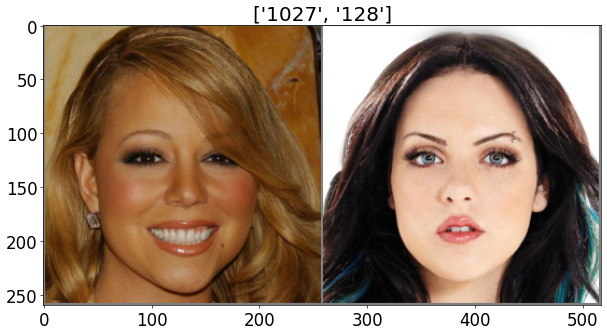

[Source Image Examples]


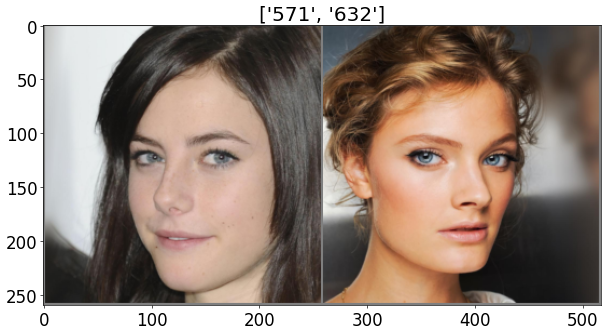

[Adversarial Examples]


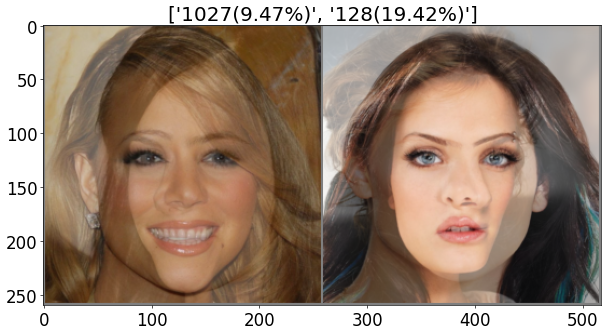

Query: 100 MSE: tensor([0.047987, 0.064361], device='cuda:0') linf: tensor([0.594672, 0.572250], device='cuda:0')
Time: 2.350659132003784
[Adversarial Examples]


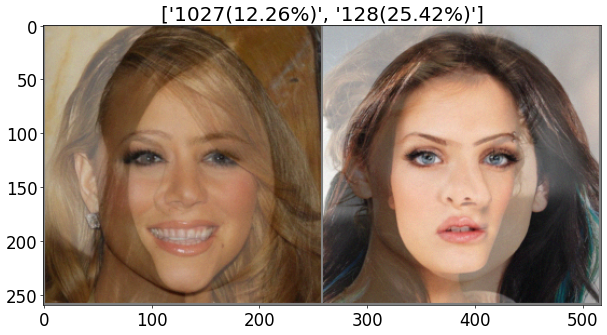

Query: 200 MSE: tensor([0.045367, 0.064357], device='cuda:0') linf: tensor([0.601328, 0.584983], device='cuda:0')
Time: 3.6248679161071777
[Adversarial Examples]


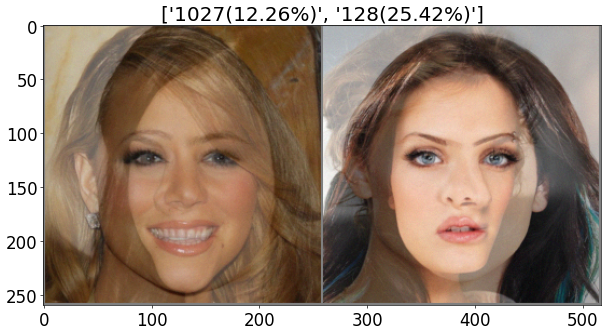

Query: 300 MSE: tensor([0.045367, 0.064357], device='cuda:0') linf: tensor([0.601328, 0.584983], device='cuda:0')
Time: 5.049014329910278
[Adversarial Examples]


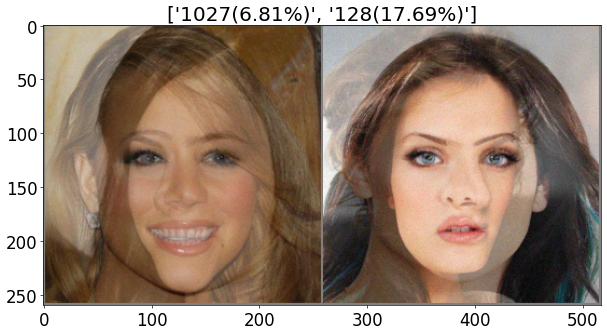

Query: 500 MSE: tensor([0.039301, 0.063292], device='cuda:0') linf: tensor([0.569700, 0.607449], device='cuda:0')
Time: 6.825063467025757
[Adversarial Examples]


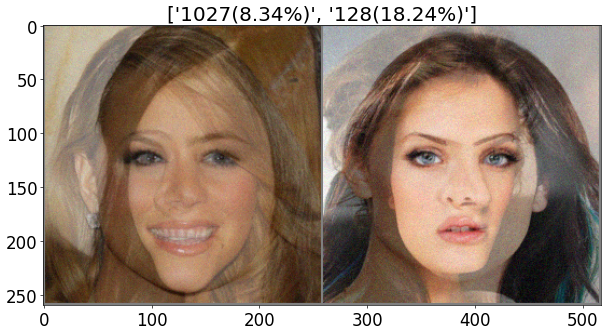

Query: 1000 MSE: tensor([0.035347, 0.056033], device='cuda:0') linf: tensor([0.576993, 0.614382], device='cuda:0')
Time: 10.63511610031128
[Adversarial Examples]


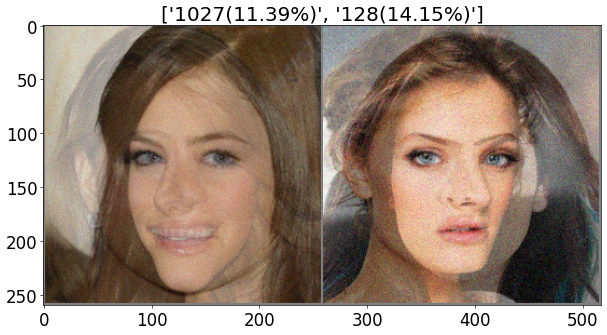

Query: 2000 MSE: tensor([0.017883, 0.035399], device='cuda:0') linf: tensor([0.439557, 0.565885], device='cuda:0')
Time: 18.054888486862183
[Adversarial Examples]


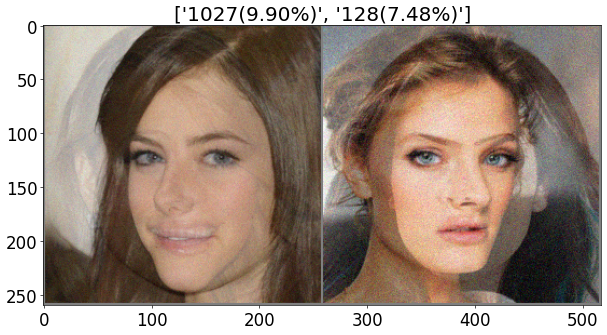

Query: 3000 MSE: tensor([0.010513, 0.024800], device='cuda:0') linf: tensor([0.355539, 0.497225], device='cuda:0')
Time: 25.772183656692505
[Adversarial Examples]


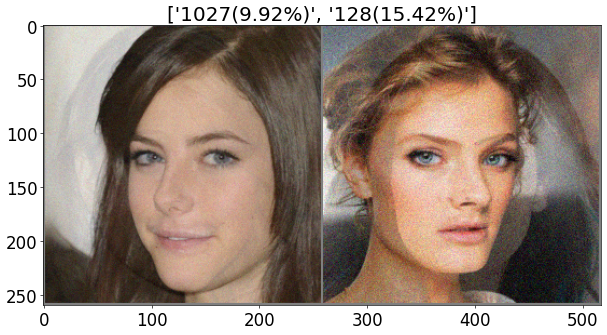

Query: 5000 MSE: tensor([0.004611, 0.012566], device='cuda:0') linf: tensor([0.243605, 0.398039], device='cuda:0')
Time: 39.85698175430298
[Adversarial Examples]


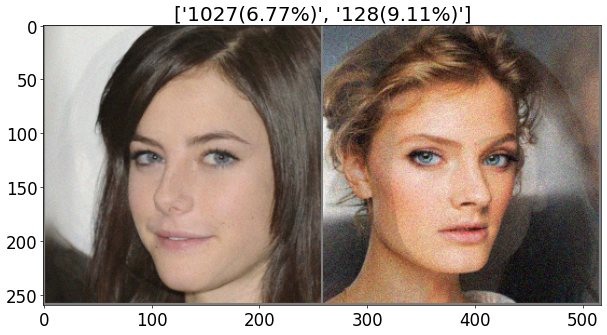

Query: 8000 MSE: tensor([0.001429, 0.005790], device='cuda:0') linf: tensor([0.143348, 0.290423], device='cuda:0')
Time: 60.752641677856445
[Adversarial Examples]


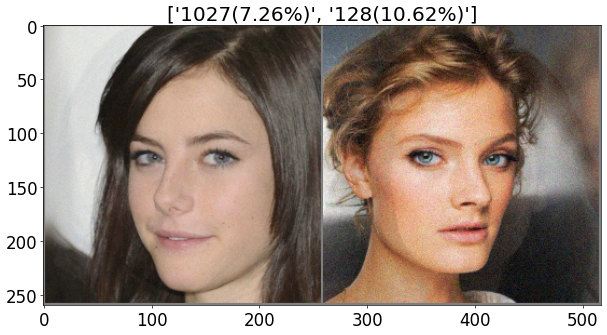

Query: 10000 MSE: tensor([0.000872, 0.003052], device='cuda:0') linf: tensor([0.116993, 0.230489], device='cuda:0')
Time: 75.82536625862122


In [ ]:
start_time = time.time()

# the default batch size of the attack is 1
for i in range(0, images_num, attack_batch):
    if i < checkpoint:
        continue
        
    source_inputs, source_labels = final_test_dataset[source_index[i]]
    target_inputs, target_labels = final_test_dataset[target_index[i]]
    
    source_inputs = source_inputs.unsqueeze(0).cuda()
    source_labels = torch.tensor([source_labels]).long().cuda()
    target_inputs = target_inputs.unsqueeze(0).cuda()
    target_labels = torch.tensor([target_labels]).long().cuda()
    
    for j in range(i + 1, i + attack_batch):
        source_input, source_label = final_test_dataset[source_index[j]]
        target_input, target_label = final_test_dataset[target_index[j]]
        
        source_input = source_input.unsqueeze(0).cuda()
        source_label = torch.tensor([source_label]).long().cuda()
        target_input = target_input.unsqueeze(0).cuda()
        target_label = torch.tensor([target_label]).long().cuda()

        # make a batch
        source_inputs = torch.cat([source_inputs, source_input], dim=0)
        source_labels = torch.cat([source_labels, source_label], dim=0)
        target_inputs = torch.cat([target_inputs, target_input], dim=0)
        target_labels = torch.cat([target_labels, target_label], dim=0)

    # the encoded target image G(w_trg) should be classified as a target label
    with torch.no_grad():
        outputs = model(target_inputs)
        _, preds = torch.max(outputs, 1)

    percentages = torch.nn.functional.softmax(outputs, dim=1) * 100.
    one_hot_labels = torch.eye(len(outputs[0]))[preds].cuda()
    probs = torch.masked_select(percentages, one_hot_labels.bool())
    correct = preds == target_labels

    # F(G(w_trg)) should be y_trg for the decision-based attack
    if not correct.sum() == attack_batch:
        continue

    print('[Target Image Examples]')
    images = torchvision.utils.make_grid(target_inputs)
    imshow(images.cpu(), title=f'{[class_names[x] for x in target_labels]}')

    with torch.no_grad():
        outputs = model(source_inputs)
        _, preds = torch.max(outputs, 1)

    percentages = torch.nn.functional.softmax(outputs, dim=1) * 100.
    one_hot_labels = torch.eye(len(outputs[0]))[preds].cuda()
    probs = torch.masked_select(percentages, one_hot_labels.bool())
    correct = preds == target_labels

    print('[Source Image Examples]')
    images = torchvision.utils.make_grid(source_inputs)
    imshow(images.cpu(), title=f'{[class_names[x] for x in source_labels]}')

    # start the attack process
    for j in range(attack_batch):
        log_path = f'{result_path}/{i + j}/'
        os.makedirs(log_path, exist_ok=True)
        save_image(unnormalize(source_inputs[j:j+1]), log_path + f'source.png')
        save_image(unnormalize(target_inputs[j:j+1]), log_path + f'target.png')
        with open(log_path + 'log', 'a') as f:
            f.write(f'{str(class_names[source_labels[j].item()])} {str(class_names[target_labels[j].item()])}\n')
        
    attack_criterion = criteria.TargetedMisclassification(target_labels)
    
    unnormalized_source_inputs = unnormalize(source_inputs).cuda()
    unnormalized_target_inputs = unnormalize(target_inputs).cuda()

    custom_network.setup(unnormalized_source_inputs, unnormalized_target_inputs, bound, target_labels, 0, set(log), log_path, i, unnormalized_source_inputs, source_labels)
    _, _, _ = attack(fmodel, unnormalized_source_inputs, criterion=attack_criterion, starting_points=unnormalized_target_inputs, epsilons=None) # adversarial attack

    # display adversarial examples
    with torch.no_grad():
        outputs = model(normalize(custom_network.result))
        _, preds = torch.max(outputs, 1)

    percentages = torch.nn.functional.softmax(outputs, dim=1) * 100.
    one_hot_labels = torch.eye(len(outputs[0]))[preds].cuda()
    probs = torch.masked_select(percentages, one_hot_labels.bool())

    print('[Adversarial Examples]')
    images = torchvision.utils.make_grid(normalize(custom_network.result))
    imshow(images.cpu(), title=[str(class_names[pred.item()]) + "({:.2f}%)".format(prob) for pred, prob in zip(preds, probs)]) 

    # start the attack process
    for j in range(attack_batch):
        log_path = f'{result_path}/{i + j}/'
        os.makedirs(log_path, exist_ok=True)
        save_image(custom_network.result[j:j+1], log_path + f'adversarial_example.png')